Abstract

250 words or less. Identify 4-6 key phrases.

# Background

In most classical statistical theories, random variables are assumed to have Gaussian distributions. How about non-Gaussian cases? Driven by curiosity, we read the paper “Independent component analysis: algorithm and applications”. ICA is a general-purpose statistical technique, with a lot of interesting application in audio processing, biomedical signal processing, image processing, telecommunications, and econometrics. Inspired by cocktail-party problem, ICA attempts to separate mixed signals. Specifically, under the key assumption of non-Gaussianity, ICA gives a linear representation of multivariate data with statistically independent components. 

## Independent Component Analysis

### Definition

Assume that we observe $n$ linear variables  $x_1, x_2,…, x_n$. They are mixtures of $m$ independent variables $s_1, s_2,…, s_m$:

$$x_i = a_{i1}s_1+a_{i2}s_2+...+a_{im}s_m$$

The fundamental point is that we observe only the variables $x_i$, whereas both $a_{ij}$ and $s_j$ are to be estimated or inferred. The $s_j$ are the independent components, whereas the coefficients $x_i$ are called the mixing coefficients. Using a vector-matrix notation, the above mixing is written as:

$$x=As.$$

In other words, all we observe is the random vector $x$, and we want to estimate both $A$ and $s$.

### Principles of ICA estimation

#### ``Nongaussian is independent''

The Central Limit Theorem tells that the distribution of a sum of independent random variables tends toward a Gaussian distribution, under certain conditions. Thus, a sum of two independent random variables usually has a distribution that is closer to gaussian than any of the two original random variables.

Let’s consider a linear combination of $x_i$: $y=w^Tx = \sum w_i x_i$, where $w$ is a vector to be determined. Denote $z=A^T w$, then we have $y=w^T x=w^T, As= z^T s$. $y$ is thus a linear combination of $s_i$, with weights given by $z_i$. Since a sum of even two independent random variables is more Gaussian than the original variables,  $z^T s$ is more Gaussian than any of the $s_i$ and becomes least Gaussian when it in fact equals one of the $s_i$. In this case, obviously only one of the elements $z_i$ of $z$ is nonzero.

Therefore, we could take as $w$ a vector that maximizes the non-Gaussianity of  $w^T x$. Such a vector would necessarily correspond (in the transformed coordinate system) to a $z$ which has only one nonzero component. This means that $w^T x= z^T s$ equals one of the independent component. Maximizing the non-Gaussianity of  $w^T x$ thus gives us one of the independent components.

### Measures of non-Gaussianity

Here we use approximations of negentropy. Paper “New approximations of differential entropy for independent component analysis and projection pursuit” developed approximations based on the maximum-entropy principle:
$$J(y) \approx \sum_{i=1}^{p} k_i \left[ E \left[G_i (y)\right]-E\left[G_i (v)\right]\right]^2 $$
where $k_i$ are some positive constants, and $v$ is a Gaussian variable of zero mean and unit variance (i.e., standardized). The variable $v$ is assumed to be of zero mean and unit variance, and the functions $G_i$ are some nonquadratic functions. To obtain relatively robust estimators, the following choices of $G$ have proved very useful:
$$G_1 (u) = \frac{1}{a_1}  log⁡cosh⁡\left(a_1 u\right) ,where 1≤a_1≤2$$

$$G_2 (u)=-exp⁡(-u^2/2)$$



## Preprocessing for ICA

Before applying an ICA algorithm, centering and whitening data will make the problem simpler and better conditioned.

# Algorithm

In [ ]:
%load test.py

In [27]:
# data
%run test.py
%run fMRI.py

In [22]:
%run fastICA_0.py
%run fastICA_better_algo.py
%run fastICA_jit.py
%run fastICA_ne.py

### Code Profiling and Optimization

#### line_profiler

In [10]:
!python -m line_profiler fastICA_00.py.lprof

Timer unit: 1e-06 s

Total time: 3.12716 s
File: fastICA_00.py
Function: fastICA_00 at line 31

Line #      Hits         Time  Per Hit   % Time  Line Contents
    31                                           @profile
    32                                           def fastICA_00(X, f,alpha=None, n_comp=None,maxit=200, tol=1e-04):
    33                                               """FastICA algorithm for several units"""
    34         1            3      3.0      0.0      n,p = X.shape
    35                                               #check if n_comp is valid
    36         1            1      1.0      0.0      if n_comp is None:
    37                                                   n_comp = min(n,p)
    38         1            2      2.0      0.0      elif n_comp > min(n,p):
    39                                                   print("n_comp is too large")
    40                                                   n_comp = min(n,p)
    41                                   

#### Bottlenecks
We used line profiler to identify the bottlenecks.
From the result, it can be observed that the biggest bottleneck in the fastica function are "np.tanh" ("g_logcosh" and "gprime_logcosh") and 'np.linalg.svd' function, which take about 90% percent of the time when running fastica function. The next bottleneck are 'preprocessing.scale'and matrix dot product.

#### Comparison

We show the improved efficiency below for all major update functions.

In [11]:
%timeit -r2 -n4 fastICA_0(fMRI,f = "logcosh",n_comp =20, alpha = 1,maxit = 200, tol = 0.0001)

4 loops, best of 2: 2.49 s per loop


In [16]:
%timeit -r2 -n4 fastICA_3(fMRI,f = "logcosh",n_comp =20, alpha = 1,maxit = 200, tol = 0.0001)

4 loops, best of 2: 65 ms per loop


In [18]:
%timeit -r2 -n4 fastICA_3jit(fMRI,f = "logcosh",n_comp =20, alpha = 1,maxit = 200, tol = 0.0001)

4 loops, best of 2: 63.4 ms per loop


In [20]:
%timeit -r2 -n4 fastICA_3ne(fMRI,f = "logcosh",n_comp =20, alpha = 1,maxit = 200, tol = 0.0001)

4 loops, best of 2: 39 ms per loop


### Application

#### Simulated Test Data

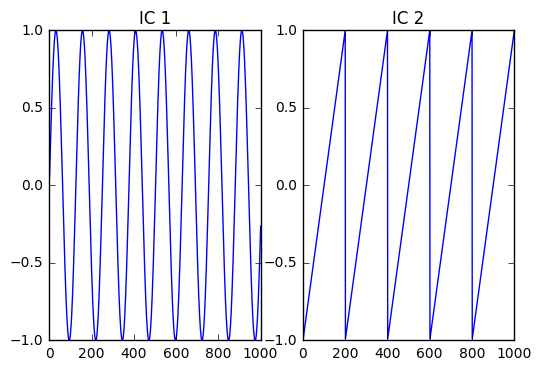

In [28]:
test(S_test)